# Sparkify Project Workspace
This workspace contains a tiny subset (128MB) of the full dataset available (12GB). Feel free to use this workspace to build your project, or to explore a smaller subset with Spark before deploying your cluster on the cloud. Instructions for setting up your Spark cluster is included in the last lesson of the Extracurricular Spark Course content.

You can follow the steps below to guide your data analysis and model building portion of this project.

In [ ]:
# import libraries
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.sql.types import IntegerType, StringType
from pyspark.sql.functions import desc,asc,col,sum as Fsum,udf


from pyspark.ml.feature import VectorAssembler,StringIndexer,StandardScaler
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression,GBTClassifier,NaiveBayes
from pyspark.ml.evaluation import MulticlassClassificationEvaluator


import matplotlib.dates as mdates
import datetime
import httpagentparser


import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

In [5]:
# create a Spark session

# Create spark session
spark = SparkSession \
    .builder \
    .appName("Sparkify") \
    .getOrCreate()



# Load and Clean Dataset
In this workspace, the mini-dataset file is `mini_sparkify_event_data.json`. Load and clean the dataset, checking for invalid or missing data - for example, records without userids or sessionids. 

In [6]:
# Read in full sparkify dataset
event_data = "mini_sparkify_event_data.json"
df = spark.read.json(event_data)
df.head()

Row(artist='Martha Tilston', auth='Logged In', firstName='Colin', gender='M', itemInSession=50, lastName='Freeman', length=277.89016, level='paid', location='Bakersfield, CA', method='PUT', page='NextSong', registration=1538173362000, sessionId=29, song='Rockpools', status=200, ts=1538352117000, userAgent='Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0', userId='30')

In [7]:
df.describe()

DataFrame[summary: string, artist: string, auth: string, firstName: string, gender: string, itemInSession: string, lastName: string, length: string, level: string, location: string, method: string, page: string, registration: string, sessionId: string, song: string, status: string, ts: string, userAgent: string, userId: string]

In [8]:
print('number of dataset with null artist : ' ,df.where(col("artist").isNull()).count())
print('number of dataset with null userid : ' ,df.where(col("userId").isNull()).count())
print('number of dataset with null sessionid : ' ,df.where(col("sessionId").isNull()).count())
print('number of dataset with empty userid : ' ,df.where(col("userId") == '').count())
print('number of dataset with empty sessionid : ' ,df.where(col("sessionid") == '').count())

number of dataset with null artist :  58392
number of dataset with null userid :  0
number of dataset with null sessionid :  0
number of dataset with empty userid :  8346
number of dataset with empty sessionid :  0


In [9]:
#filter empty string
df_cleaned = df.filter(df.userId != '')

In [10]:
#Check duplicates
print("all data : ",df_cleaned.count())
print("non duplicate data : ", df_cleaned.drop_duplicates().count())
if df_cleaned.count()==df_cleaned.drop_duplicates().count():
    print('No duplicate')
else:
    print('duplicate dataset')

all data :  278154
non duplicate data :  278154
No duplicate


# Exploratory Data Analysis
When you're working with the full dataset, perform EDA by loading a small subset of the data and doing basic manipulations within Spark. In this workspace, you are already provided a small subset of data you can explore.

### Define Churn

Once you've done some preliminary analysis, create a column `Churn` to use as the label for your model. I suggest using the `Cancellation Confirmation` events to define your churn, which happen for both paid and free users. As a bonus task, you can also look into the `Downgrade` events.

### Explore Data
Once you've defined churn, perform some exploratory data analysis to observe the behavior for users who stayed vs users who churned. You can start by exploring aggregates on these two groups of users, observing how much of a specific action they experienced per a certain time unit or number of songs played.

In [11]:
#Distribution of gender
df_cleaned.groupby('gender').count().show()

+------+------+
|gender| count|
+------+------+
|     F|154578|
|     M|123576|
+------+------+



In [12]:
#Statistical result of song length
df_cleaned.select('length').describe().show()

+-------+-----------------+
|summary|           length|
+-------+-----------------+
|  count|           228108|
|   mean|249.1171819778458|
| stddev|99.23517921058361|
|    min|          0.78322|
|    max|       3024.66567|
+-------+-----------------+



In [13]:
df_cleaned.groupby('page').count().sort('count').show()

+--------------------+------+
|                page| count|
+--------------------+------+
|              Cancel|    52|
|Cancellation Conf...|    52|
|    Submit Downgrade|    63|
|      Submit Upgrade|   159|
|               Error|   252|
|       Save Settings|   310|
|               About|   495|
|             Upgrade|   499|
|                Help|  1454|
|            Settings|  1514|
|           Downgrade|  2055|
|         Thumbs Down|  2546|
|              Logout|  3226|
|         Roll Advert|  3933|
|          Add Friend|  4277|
|     Add to Playlist|  6526|
|                Home| 10082|
|           Thumbs Up| 12551|
|            NextSong|228108|
+--------------------+------+



In [14]:
df_cleaned.groupby('status').count().sort('count').show()

+------+------+
|status| count|
+------+------+
|   404|   252|
|   307| 23184|
|   200|254718|
+------+------+



In [15]:
df_cleaned.createOrReplaceTempView("event")

In [16]:
spark.sql("""SELECT gender, COUNT(DISTINCT userId) 
             FROM event 
             WHERE page = 'Cancellation Confirmation' GROUP BY 1 
          """).show(200)

+------+----------------------+
|gender|count(DISTINCT userId)|
+------+----------------------+
|     F|                    20|
|     M|                    32|
+------+----------------------+



Total 52 users is churning

In [17]:
spark.sql("""SELECT page, COUNT(*) FROM event WHERE userId in (
             SELECT userId 
             FROM event 
             WHERE page = 'Cancellation Confirmation' LIMIT 1) GROUP BY 1 
          """).show(200)

+--------------------+--------+
|                page|count(1)|
+--------------------+--------+
|              Cancel|       1|
|         Thumbs Down|       1|
|                Home|      19|
|           Downgrade|       3|
|              Logout|       7|
|       Save Settings|       1|
|Cancellation Conf...|       1|
|               About|       1|
|            Settings|       5|
|     Add to Playlist|      14|
|          Add Friend|      10|
|            NextSong|     429|
|           Thumbs Up|      20|
|                Help|       1|
+--------------------+--------+



Example of list of page that churn user visited. If you see on the 'NextSong' page, this user played 429 songs.

In [18]:
#Create new view with churn columns
event_with_churn = spark.sql("""
SELECT e.*, COALESCE(churn,0) AS churn
FROM event e
LEFT JOIN(
        SELECT userid,1 AS churn
         FROM event 
         WHERE page = 'Cancellation Confirmation'
         GROUP BY 1
         ) USING (userid)
          """)
event_with_churn.createOrReplaceTempView("event_with_churn")

In [19]:
spark.sql(""" SELECT churn, COUNT(DISTINCT userId) FROM
event_with_churn
GROUP BY 1
""").show()

+-----+----------------------+
|churn|count(DISTINCT userId)|
+-----+----------------------+
|    1|                    52|
|    0|                   173|
+-----+----------------------+



In [20]:
spark.sql(""" 
SELECT churn, 
       AVG(cnt_song) avg_song_played,
       AVG(cnt_song/cnt_day_played) avg_song_per_day_played,
       percentile_approx(cnt_song, 0.5) median_song_played,
       AVG(cnt_unique_song)  avg_unique_song_played,
       AVG(cnt_song)/AVG(cnt_unique_song) AS unique_ratio,
       AVG(ts-registration)/(1000*3600*365*24) AS user_age
 FROM
(SELECT userId, 
        MAX(churn) AS churn, 
        SUM(CASE WHEN page = 'NextSong' THEN 1 ELSE 0 END) cnt_song,
        COUNT(DISTINCT CASE WHEN page = 'NextSong' THEN song END) cnt_unique_song,
        MAX(ts) ts,
        COUNT(DISTINCT CASE WHEN page = 'NextSong' THEN from_unixtime(ts/1000, 'yyyy-MM-dd') ELSE 0 END) cnt_day_played,
        MAX(registration) registration
   FROM event_with_churn
 GROUP BY 1) GROUP BY 1 
""").show()

+-----+------------------+-----------------------+------------------+----------------------+------------------+-----------------+
|churn|   avg_song_played|avg_song_per_day_played|median_song_played|avg_unique_song_played|      unique_ratio|         user_age|
+-----+------------------+-----------------------+------------------+----------------------+------------------+-----------------+
|    1| 699.8846153846154|     54.688818102889144|               429|     638.3653846153846|1.0963699352312095|3.365375499509984|
|    0|1108.1734104046243|      58.45847338629526|               747|     975.7687861271677|1.1356926212027865|5.086918406793906|
+-----+------------------+-----------------------+------------------+----------------------+------------------+-----------------+



On average, churn user played less song compared to active user. They also have less in user_age (3.3 years compare to 5 years). 

In [21]:
spark.sql("SELECT level, COUNT(*) FROM event_with_churn GROUP BY 1").show()

+-----+--------+
|level|count(1)|
+-----+--------+
| free|   55721|
| paid|  222433|
+-----+--------+



In [22]:
df_song_perday = spark.sql(""" 
SELECT churn, 
       cnt_song/cnt_day_played num_song_perday
 FROM
(SELECT userId, 
        MAX(churn) AS churn, 
        SUM(CASE WHEN page = 'NextSong' THEN 1 ELSE 0 END) cnt_song,
        MAX(ts) ts,
        COUNT(DISTINCT CASE WHEN page = 'NextSong' THEN from_unixtime(ts/1000, 'yyyy-MM-dd') ELSE 0 END) cnt_day_played,
        MAX(registration) registration
   FROM event_with_churn
 GROUP BY 1) 
""").toPandas()

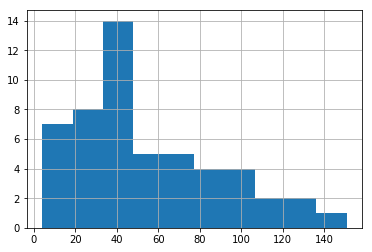

In [21]:
df_song_perday[df_song_perday.churn == 1].num_song_perday.hist()

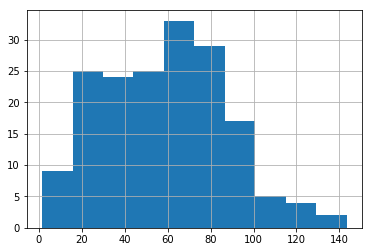

In [22]:
df_song_perday[df_song_perday.churn == 0].num_song_perday.hist()

Churn user has right skewed distribution in terms of song per day, which means they play less song per day. On the other hand, active users is more similar to normal distribution.

# Feature Engineering
Once you've familiarized yourself with the data, build out the features you find promising to train your model on. To work with the full dataset, you can follow the following steps.
- Write a script to extract the necessary features from the smaller subset of data
- Ensure that your script is scalable, using the best practices discussed in Lesson 3
- Try your script on the full data set, debugging your script if necessary

If you are working in the classroom workspace, you can just extract features based on the small subset of data contained here. Be sure to transfer over this work to the larger dataset when you work on your Spark cluster.

In [23]:
#Create dummy column
def create_dummy_columns(col_name,df):
    '''
    Input :
    - col_name = name of the column that is used to generate dummy variables
    - df = spark df
    Output :
    - ndf = new spark df with all dummy variables from selected column
    '''
    elements = df.select(col_name).distinct().rdd.flatMap(lambda x: x).collect()
    exprs = [F.when(F.col(col_name) == element, 1).otherwise(0).alias(element)
         for element in elements]
    df_with_dummy = df.select("*", *exprs)
    
    #drop original column
    ndf = df_with_dummy.drop(col_name)
    return ndf

In [24]:
df_with_dummy_pages = create_dummy_columns('page',event_with_churn)


In [25]:
#browser
spark.udf.register("get_browser", lambda x: httpagentparser.detect(x)['browser']['name'])

#Platform
spark.udf.register("get_platform", lambda x: httpagentparser.detect(x)['platform']['name'])



<function __main__.<lambda>(x)>

In [26]:
#Check unique combination
spark.sql("SELECT get_browser(userAgent), get_platform(userAgent) FROM event_with_churn GROUP BY 1,2").show()

+----------------------+-----------------------+
|get_browser(userAgent)|get_platform(userAgent)|
+----------------------+-----------------------+
|                Chrome|                  Linux|
|               Firefox|                  Linux|
|                Safari|                    iOS|
|                Chrome|                 Mac OS|
|                Chrome|                Windows|
|                Safari|                 Mac OS|
|               Firefox|                 Mac OS|
|  Microsoft Interne...|                Windows|
|               Firefox|                Windows|
+----------------------+-----------------------+



In [27]:
#Crafting session level feature
session_feature = spark.sql("""
SELECT userId, 
       AVG(hour_per_session)             AS avg_hour_per_session,
       AVG(unique_song_per_session)      AS avg_unique_song_per_session,
       AVG(unique_artist_per_session)    AS avg_unique_artist_per_session,
       AVG(cnt_song_played_persession)   AS avg_song_played_persession
FROM (       
SELECT userId,
       sessionId,
       (MAX(ts) -MIN(ts))/(1000*3600) AS hour_per_session,
       COUNT(DISTINCT song) unique_song_per_session,
       COUNT(DISTINCT artist) unique_artist_per_session,
       SUM(CASE WHEN page = 'NextSong' THEN 1 ELSE 0 END) AS cnt_song_played_persession
FROM event_with_churn 
GROUP BY 1,2)
GROUP BY 1
""")

In [28]:
session_feature.show()

+------+--------------------+---------------------------+-----------------------------+--------------------------+
|userId|avg_hour_per_session|avg_unique_song_per_session|avg_unique_artist_per_session|avg_song_played_persession|
+------+--------------------+---------------------------+-----------------------------+--------------------------+
|100010|   2.574722222222223|         39.142857142857146|            38.57142857142857|        39.285714285714285|
|200002|                4.44|          64.16666666666667|           62.166666666666664|                      64.5|
|   125| 0.49277777777777776|                        8.0|                          8.0|                       8.0|
|    51|  14.539277777777775|                      204.1|                        188.2|                     211.1|
|   124|   9.649904214559387|         137.24137931034483|            127.6896551724138|         140.6551724137931|
|     7|  1.4606746031746032|         21.428571428571427|                       

In [29]:
session_feature.createOrReplaceTempView('session_feature')

In [38]:
#Crafting the feature
full_feature = spark.sql("""
SELECT userId,
       churn,  
       --Gender
       MAX(CASE WHEN gender = 'M' THEN 1 ELSE 0 END)  AS gender_male,
       MAX(CASE WHEN gender = 'F' THEN 1 ELSE 0 END) AS gender_female,
       
       -- browser
       MAX(CASE WHEN get_browser(userAgent) = 'Chrome' THEN 1 ELSE 0 END)  AS chrome_user,
       MAX(CASE WHEN get_browser(userAgent) = 'Firefox' THEN 1 ELSE 0 END)  AS firefox_user,
       MAX(CASE WHEN get_browser(userAgent) = 'Safari' THEN 1 ELSE 0 END)  AS safari_user,
       MAX(CASE WHEN get_browser(userAgent) LIKE '%Microsoft%' THEN 1 ELSE 0 END)  AS ie_user,
       
       --platform
       MAX(CASE WHEN get_platform(userAgent) = 'Linux' THEN 1 ELSE 0 END)  AS linux_user,
       MAX(CASE WHEN get_platform(userAgent) = 'iOS' THEN 1 ELSE 0 END)  AS ios_user,
       MAX(CASE WHEN get_platform(userAgent) = 'Mac OS' THEN 1 ELSE 0 END)  AS mac_user,
       MAX(CASE WHEN get_platform(userAgent) = 'Windows' THEN 1 ELSE 0 END)  AS windows_user,
       
       
       
       
       -- Paid and free session
       COUNT(DISTINCT CASE WHEN level = 'paid' THEN sessionId ELSE 0 END) AS cnt_paid_session,
       COUNT(DISTINCT CASE WHEN level = 'free' THEN sessionId ELSE 0 END) AS cnt_free_session,
       
       -- Artist and song behavior
       COUNT(DISTINCT artist) AS cnt_unique_artist,
       COUNT(DISTINCT song) AS cnt_unique_song,
       AVG(length) AS average_song_length,
       SUM(CASE WHEN page = 'NextSong' THEN 1 ELSE 0 END) AS cnt_song_played,
    
       -- Other behavior
       COUNT(DISTINCT CASE WHEN page = 'NextSong' THEN from_unixtime(ts/1000, 'yyyy-MM-dd') ELSE 0 END) AS cnt_day_played,
       COUNT(DISTINCT sessionId) AS cnt_session,
       SUM(CASE WHEN page = 'Add Friend' THEN 1 ELSE 0 END) AS cnt_add_friend,
       SUM(CASE WHEN page = 'Thumbs Down' THEN 1 ELSE 0 END) AS cnt_thumb_down,
       SUM(CASE WHEN page = 'Thumbs Up' THEN 1 ELSE 0 END) AS cnt_thumbs_up,
       SUM(CASE WHEN page = 'Home' THEN 1 ELSE 0 END) AS cnt_home,
       SUM(CASE WHEN page = 'Logout' THEN 1 ELSE 0 END) AS cnt_logout,
       SUM(CASE WHEN page = 'Help' THEN 1 ELSE 0 END) AS cnt_help,
       SUM(CASE WHEN page = 'Settings' THEN 1 ELSE 0 END) AS cnt_settings,
       SUM(CASE WHEN page = 'Submit Downgrade' THEN 1 ELSE 0 END) AS cnt_submit_downgrade,
       SUM(CASE WHEN page = 'Submit Upgrade' THEN 1 ELSE 0 END) AS cnt_submit_upgrade,
       SUM(CASE WHEN page = 'Downgrade' THEN 1 ELSE 0 END) AS cnt_initiate_downgrade,
       SUM(CASE WHEN page = 'Upgrade' THEN 1 ELSE 0 END) AS cnt_initiate_upgrade,
       SUM(CASE WHEN page = 'Error' THEN 1 ELSE 0 END) AS cnt_error,
       MAX(ts-registration)/(1000*3600*365*24) AS user_age,
       
       --Combining session feature
       MAX(sf.avg_hour_per_session)  AS avg_hour_per_session,
       MAX(sf.avg_unique_song_per_session) AS avg_unique_song_per_session,
       MAX(sf.avg_unique_artist_per_session) AS avg_unique_artist_per_session,
       MAX(sf.avg_song_played_persession) AS avg_song_played_persession
    
FROM event_with_churn 
LEFT JOIN session_feature sf USING (userId)
GROUP BY 1,2     
""")

In [39]:
#fairly slow
full_feature.persist()

DataFrame[userId: string, churn: int, gender_male: int, gender_female: int, chrome_user: int, firefox_user: int, safari_user: int, ie_user: int, linux_user: int, ios_user: int, mac_user: int, windows_user: int, cnt_paid_session: bigint, cnt_free_session: bigint, cnt_unique_artist: bigint, cnt_unique_song: bigint, average_song_length: double, cnt_song_played: bigint, cnt_day_played: bigint, cnt_session: bigint, cnt_add_friend: bigint, cnt_thumb_down: bigint, cnt_thumbs_up: bigint, cnt_home: bigint, cnt_logout: bigint, cnt_help: bigint, cnt_settings: bigint, cnt_submit_downgrade: bigint, cnt_submit_upgrade: bigint, cnt_initiate_downgrade: bigint, cnt_initiate_upgrade: bigint, cnt_error: bigint, user_age: double, avg_hour_per_session: double, avg_unique_song_per_session: double, avg_unique_artist_per_session: double, avg_song_played_persession: double]

# Modeling
Split the full dataset into train, test, and validation sets. Test out several of the machine learning methods you learned. Evaluate the accuracy of the various models, tuning parameters as necessary. Determine your winning model based on test accuracy and report results on the validation set. Since the churned users are a fairly small subset, I suggest using F1 score as the metric to optimize.

In [68]:
features_col = ['gender_male','gender_female','chrome_user','firefox_user','safari_user',
               'ie_user','linux_user','ios_user','mac_user','windows_user','cnt_paid_session',
               'cnt_free_session','cnt_unique_artist','cnt_unique_song','average_song_length',
               'cnt_song_played','cnt_day_played','cnt_session','cnt_add_friend','cnt_thumb_down',
               'cnt_thumbs_up','cnt_home','cnt_logout','cnt_help','cnt_settings','cnt_submit_downgrade',
               'cnt_submit_upgrade','cnt_initiate_downgrade','cnt_initiate_upgrade','cnt_error',
               'user_age','avg_hour_per_session','avg_unique_song_per_session','avg_unique_artist_per_session'
                ]
assembler = VectorAssembler(inputCols=features_col, outputCol="feature_vec")

df = assembler.transform(full_feature)
train, test = df.randomSplit([0.8, 0.2], seed=42)

indexer = StringIndexer(inputCol="churn", outputCol="label")
scaler = StandardScaler(inputCol="feature_vec", outputCol="scaled_features")



Logistic Regression as Benchmark

In [75]:

lr =  LogisticRegression(maxIter=10, regParam=0.0, elasticNetParam=0, featuresCol='scaled_features')
pipeline_logreg = Pipeline(stages=[indexer, scaler, lr])
paramGrid = ParamGridBuilder().addGrid(lr.regParam,[0.0, 0.1, 1]).build()

crossval_lr = CrossValidator(estimator=pipeline_logreg,
                          estimatorParamMaps=paramGrid,
                          evaluator=MulticlassClassificationEvaluator(metricName='f1'),
                          numFolds=3)

In [76]:
cvModel_lr = crossval_lr.fit(train)
print('F1 score for LogReg model in train :',  cvModel_lr.avgMetrics)
results_lr = cvModel_lr.transform(test)

In [77]:
print("Accuracy for Logistic Regression Model in test: ", results_lr.filter(results_lr.label == results_lr.prediction).count()/ results_lr.count())
evaluator = MulticlassClassificationEvaluator(metricName='f1')
score = evaluator.evaluate(results_lr)
print("F1 score for Logistic Regression model in test : ", score)

Accuracy for Logistic Regression Model is:  0.8222222222222222
F1 score for Logistic Regression model is :  0.7720797720797721


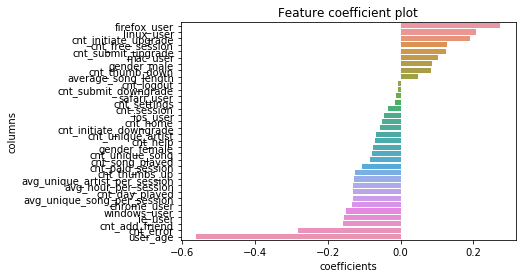

In [91]:
feature_importances = cvModel_lr.bestModel.stages[-1].coefficients.values.tolist()

def plot_feature(feature_importances, features_col):
    feature_importance_df = pd.DataFrame({'coefficients': feature_importances, 'columns': features_col})
    graph = sns.barplot(x='coefficients', y='columns', data=feature_importance_df.sort_values('coefficients',ascending=False))
    graph.set_title('Feature coefficient plot')
    
    
plot_feature(feature_importances,features_col)

Gradient Boosting Model

In [82]:
gbt = GBTClassifier(labelCol="label", featuresCol="scaled_features", maxIter=10)
pipeline_gbt = Pipeline(stages=[indexer, scaler, gbt])
paramGrid = ParamGridBuilder().build()

crossval_gbt = CrossValidator(estimator=pipeline_gbt,
                          estimatorParamMaps=paramGrid,
                          evaluator=MulticlassClassificationEvaluator(metricName='f1'),
                          numFolds=3)

In [86]:
cvModel_gbt = crossval_gbt.fit(train)
print('F1 score for GBT model in train :',  cvModel_gbt.avgMetrics)
results_gbt = cvModel_gbt.transform(test)

In [88]:
print('F1 score for GBT model in train :',  cvModel_gbt.avgMetrics)


F1 score for GBT model in train : [0.7073004669308084]


In [87]:
print("Accuracy for GBT Model in test: ", results_gbt.filter(results_gbt.label == results_gbt.prediction).count()/ results_gbt.count())
evaluator = MulticlassClassificationEvaluator(metricName='f1')
score = evaluator.evaluate(results_gbt)
print("F1 score for GBT model in test : ", score)

Accuracy for GBT Model is:  0.7111111111111111
F1 score for GBT model is :  0.7055432007248168


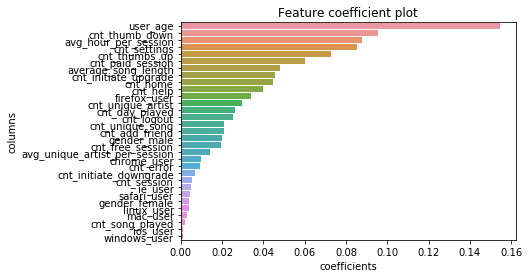

In [112]:
feature_importances = cvModel_gbt.bestModel.stages[2].featureImportances.values.tolist()
gbt_col = [features_col[x] for x in cvModel_gbt.bestModel.stages[2].featureImportances.indices.tolist()]

plot_feature(feature_importances,gbt_col)

Naive Bayes

In [115]:

nb = NaiveBayes(smoothing=1.0, modelType="multinomial",featuresCol='scaled_features')
pipeline = Pipeline(stages=[indexer, scaler, nb])
paramGrid = ParamGridBuilder().build()

crossval_nb = CrossValidator(estimator=pipeline,
                          estimatorParamMaps=paramGrid,
                          evaluator=MulticlassClassificationEvaluator(metricName='f1'),
                          numFolds=3)


In [117]:
cvModel_nb = crossval_nb.fit(train)
print('F1 score for Naive bayes model in train :',  cvModel_nb.avgMetrics)
results_nb = cvModel_nb.transform(test)

F1 score for Naive bayes model in train : [0.6300246899553191]


In [118]:
print("Accuracy for NB Model in test: ", results_nb.filter(results_nb.label == results_nb.prediction).count()/ results_nb.count())
evaluator = MulticlassClassificationEvaluator(metricName='f1')
score = evaluator.evaluate(results_nb)
print("F1 score for NB model in test : ", score)

Accuracy for NB Model in test:  0.5777777777777777
F1 score for NB model in test :  0.6121474781734816


# Final Steps
Clean up your code, adding comments and renaming variables to make the code easier to read and maintain. Refer to the Spark Project Overview page and Data Scientist Capstone Project Rubric to make sure you are including all components of the capstone project and meet all expectations. Remember, this includes thorough documentation in a README file in a Github repository, as well as a web app or blog post.